<a href="https://colab.research.google.com/github/DerManjuel/MDL/blob/main/MDL_Exercise5_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Deep Learning
## Exercise 5: Model Distillation & Ternary Nets

The goal of this exercise is to implement methods that allow to compress deep learning models via model distillation and ternary weights. This enables the use of deep learning in medicine due to its real-time ability and implementation on weaker mobile devices.

In [1]:
import torch
# Set the device
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda"
print(device)

mps


In [3]:
#run pip install for pytorch flop counter before first use
#!pip install onnx wget
#!pip install --upgrade git+https://github.com/Lyken17/pytorch-OpCounter.git

import torchvision
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil,gzip
#import wget

#some functions to count unique parameters and sparsity are provided
def countParameters(net):
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([p.numel() for p in model_parameters])
    return params

def countUnique(net):
    unique = 0
    for m in net.modules():
        if(isinstance(m,nn.Conv2d)):
            unique += len(np.unique(m.weight.data.cpu().flatten().numpy()))
    return unique
    #print('#unique',unique)

def countSparsity(net):
    count_nonzero = 0; count_zero = 0
    for m in net.modules():
        if(isinstance(m, nn.Conv2d)):
            count_nonzero += torch.sum((m.weight.data!=0).float())
            count_zero += torch.sum((m.weight.data==0).float())
    return count_zero/(count_zero+count_nonzero)


## Dataset
We will use the data of the Patch Camelyon (tupac16) Challenge. It consists of $327\,680$ color images extracted from histopathologic scans of lymph node sections. The task is to classify the presence of metastatic tissue (global binary labels are given). The images were preprocessed to a spatial dimension of $48\times48$ and split to 65k for training and 16k for testing images. See [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) for further details.

In [4]:
#loading the patch-based wholeslide histopathology data (uint8) and converting it to torch tensors
import os

dataset_url = 'https://cloud.imi.uni-luebeck.de/s/sjjiReHqSnokJ2n/download'

def get_data(data_url):
    filename = './patchCamelyon8c.mat'
    if not os.path.exists(filename):
        #filename = wget.download(data_url)
        pass

get_data(dataset_url)


data = scipy.io.loadmat('patchCamelyon8c.mat')

img_train = torch.from_numpy(data['img_train'].astype('float32')/255)
img_test = torch.from_numpy(data['img_test'].astype('float32')/255)

label_train = torch.from_numpy(data['label_train']).long()
label_test = torch.from_numpy(data['label_test']).long()

Let's visualize an example for the two classes. You can run the cell multiple times, getting each time new random examples.

index for no metastatic tissue: 19782
index for metastatic tissue: 19992


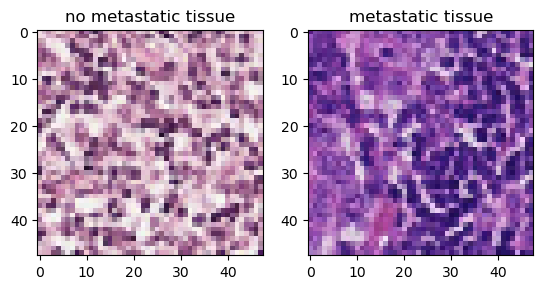

In [5]:
fig, [ax1, ax2] = plt.subplots(1, 2)
idx_negative = torch.where(label_train.squeeze() == 0)[0]
idx_negative = idx_negative[torch.randperm(len(idx_negative))[0]]

idx_positive = torch.where(label_train.squeeze() == 1)[0]
idx_positive = idx_positive[torch.randperm(len(idx_positive))[0]]

print('index for no metastatic tissue:', idx_negative.item())
print('index for metastatic tissue:', idx_positive.item())

ax1.imshow(img_train[idx_negative].permute(1, 2, 0))
ax1.set_title('no metastatic tissue')
ax2.imshow(img_train[idx_positive].permute(1, 2, 0))
ax2.set_title('metastatic tissue')
plt.show()

We load a pretrained `VGG11`, inspect its architecture and gather some computational information.

In [6]:
#!pip install torchinfo
from torchinfo import summary
net = torchvision.models.vgg11_bn(pretrained='True')

summary(net, (128, 3, 48, 48))

/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /Users/manuel/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:27<00:00, 19.2MB/s] 
/Users/manuel/miniforge3/envs/ml/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be r

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [128, 1000]               --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 48, 48]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 48, 48]         128
│    └─ReLU: 2-3                         [128, 64, 48, 48]         --
│    └─MaxPool2d: 2-4                    [128, 64, 24, 24]         --
│    └─Conv2d: 2-5                       [128, 128, 24, 24]        73,856
│    └─BatchNorm2d: 2-6                  [128, 128, 24, 24]        256
│    └─ReLU: 2-7                         [128, 128, 24, 24]        --
│    └─MaxPool2d: 2-8                    [128, 128, 12, 12]        --
│    └─Conv2d: 2-9                       [128, 256, 12, 12]        295,168
│    └─BatchNorm2d: 2-10                 [128, 256, 12, 12]        512
│    └─ReLU: 2-11                        [128, 256, 12, 12]        --


## Task 0 (15 points): Modify a pretrained VGG11_BN network for the given training data
Complete the function below, which returns a VGG11-Net with its architecture modified accordingly to match the tupac16 dataset.
+ Replace the layer `net.avgpool` with an adaptive average pool of output size $1\times1$
+ Create a new classifier as `nn.Sequential` with two linear layers ($512\times256$ and $256\times2$) including one ReLU and no batch-norm.

In [7]:
def tupac16_vgg11():
    net = torchvision.models.vgg11_bn(pretrained='True')
    net.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    net.classifier = nn.Sequential(
        nn.Linear(512,256),
        nn.Linear(256,2),
        nn.ReLU() #no batch-norm? -> YES READ ABOVE
    )

    return net

Check the reduced parameter count using `summary` from `torchinfo`. Your should obtain about $9\,357\,826$ parameters.

In [11]:
model = tupac16_vgg11()
summary(model)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       73,856
│    └─BatchNorm2d: 2-6                  256
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       295,168
│    └─BatchNorm2d: 2-10                 512
│    └─ReLU: 2-11                        --
│    └─Conv2d: 2-12                      590,080
│    └─BatchNorm2d: 2-13                 512
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      1,180,160
│    └─BatchNorm2d: 2-17                 1,024
│    └─ReLU: 2-18                        --
│    └─Conv2d: 2-19                     

## Task1 (25 points): Fine tuning
Fine-tune this network for 16 sub-epochs on the tupac16 dataset. One sub-epoch is defined as a random quarter of the training pathes. Use `torch.randperm` to generate the needed indices for every epoch. The batch size should be 128. Choose Adam as an optimizer with an initial learning rate of 0.0005 and an exponential learning rate scheduler with `gamma=0.9`. After training, evaluate the model on the test data. It should yield an accuracy about $94\%$.

**Note:** Task 2 and 3 can be performed independently, but you should store each trained network under a new filename (for comparisons). In the following all techniques should only be applied to the feature-part of the network (and not the classifier layers).

**Hint**: If you struggle with implementing of the training routine, have a look at the previous exercises.

In [12]:
# Task1 - Training loop # hier war nichts gegeben, hab ich von ex 4 übernommen
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import trange, tqdm

test_dataset = TensorDataset(img_test, label_test[0])
dl_test = DataLoader(test_dataset, batch_size=128, shuffle=True)

model.to(device)

num_epochs = 16

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0005)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# for reproducibility (do not change)
torch.manual_seed(0)

# statistics
train_loss = torch.zeros(num_epochs, device=device)
train_acc = torch.zeros_like(train_loss)

test_loss = torch.zeros_like(train_loss)
test_acc = torch.zeros_like(train_loss)

# for num_epochs
for epoch in trange(num_epochs, unit='epoch'):

    # Generate random indices for a quarter of the training paths
    quarter = len(img_train) // 4
    indices = torch.randperm(len(img_train))[:quarter]

    # Subset the dataset using the generated indices
    train_dataset = TensorDataset(img_train, label_train[0])

    subset_dataset = torch.utils.data.Subset(train_dataset, indices)

    # Create a data loader for the subset of data
    dl_train = DataLoader(subset_dataset, batch_size=128, shuffle=True)

    # train mode
    model.train()

    # for each mini-batch
    for input, target in dl_train:
        input = input.to(device)
        target = target.to(device)

        # zero the parameter gradients
        # todo
        optimizer.zero_grad()

        # forward + backward + optimize
        # todo
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # statistics
        train_loss[epoch] += loss.detach()
        train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

    # update learning rate
    # todo
    lr_scheduler.step()

    train_loss[epoch] /= len(dl_train)
    train_acc[epoch] /= len(dl_train)

    # output
    tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))

    # validate
    with torch.no_grad():

        # eval mode
        model.eval()

        # for each mini-batch
        for input, target in dl_test:
            input = input.to(device)
            target = target.to(device)

            # forward
            # todo
            output = model(input)
            loss = criterion(output, target)

            # statistics
            test_loss[epoch] += loss.detach()
            test_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

        test_loss[epoch] /= len(dl_test)
        test_acc[epoch] /= len(dl_test)

        # output
        tqdm.write('Epoch {} (valid) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, test_loss[epoch].item(), test_acc[epoch].item()))

# save trained network as tupac16_ex1.pt
torch.save(model, 'tupac16_ex1.pth')

  0%|          | 0/16 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 0.3554 accuracy: 0.8287
Epoch 0 (valid) -- loss: 0.3108 accuracy: 0.8727
Epoch 1 (train) -- loss: 0.2532 accuracy: 0.8950
Epoch 1 (valid) -- loss: 0.3060 accuracy: 0.8712
Epoch 2 (train) -- loss: 0.2199 accuracy: 0.9133
Epoch 2 (valid) -- loss: 0.2363 accuracy: 0.9057
Epoch 3 (train) -- loss: 0.1870 accuracy: 0.9283
Epoch 3 (valid) -- loss: 0.2367 accuracy: 0.9081
Epoch 4 (train) -- loss: 0.1599 accuracy: 0.9404
Epoch 4 (valid) -- loss: 0.2458 accuracy: 0.9109
Epoch 5 (train) -- loss: 0.1425 accuracy: 0.9485
Epoch 5 (valid) -- loss: 0.2450 accuracy: 0.9166
Epoch 6 (train) -- loss: 0.1204 accuracy: 0.9549
Epoch 6 (valid) -- loss: 0.2647 accuracy: 0.8958
Epoch 7 (train) -- loss: 0.1063 accuracy: 0.9622
Epoch 7 (valid) -- loss: 0.2074 accuracy: 0.9260
Epoch 8 (train) -- loss: 0.0886 accuracy: 0.9693
Epoch 8 (valid) -- loss: 0.2074 accuracy: 0.9285
Epoch 9 (train) -- loss: 0.0726 accuracy: 0.9753
Epoch 9 (valid) -- loss: 0.1984 accuracy: 0.9356
Epoch 10 (train) -- 

## Task 2 (60 points): Network Pruning through increased Sparsity
+ Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before by calling your `tupac16_vgg11` method.
+ Reuse the training routine from above.
+ Add a sparsity promoting L1-loss (sum of absolute values) with a weight factor of 0.04 to the classification loss on the weights and bias of each BatchNorm2d.
    + Therefor iterate over all modules of the net using `modules()` and determine the layer type using `isinstance()`
+ Retrain the network.
+ Evaluate its test accuracy (will drop slightly to ~89%).

In [37]:
def l1_sparse_loss(layer):
    #print('l1_sparse_loss:', torch.sum(abs(layer.weight))+torch.sum(abs(layer.bias)))
    return torch.sum(abs(layer.weight)) + torch.sum(abs(layer.bias))

In [38]:
# Task 2
model = tupac16_vgg11()

# Task1 - Training loop # hier war nichts gegeben, hab ich von ex 4 übernommen
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import trange, tqdm

test_dataset = TensorDataset(img_test, label_test[0])
dl_test = DataLoader(test_dataset, batch_size=128, shuffle=True)

model.to(device)

num_epochs = 16

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0005)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# for reproducibility (do not change)
torch.manual_seed(0)

# statistics
train_loss = torch.zeros(num_epochs, device=device)
train_acc = torch.zeros_like(train_loss)

test_loss = torch.zeros_like(train_loss)
test_acc = torch.zeros_like(train_loss)

# for num_epochs
for epoch in trange(num_epochs, unit='epoch'):

    # Generate random indices for a quarter of the training paths
    quarter = len(img_train) // 4
    indices = torch.randperm(len(img_train))[:quarter]

    # Subset the dataset using the generated indices
    train_dataset = TensorDataset(img_train, label_train[0])

    subset_dataset = torch.utils.data.Subset(train_dataset, indices)

    # Create a data loader for the subset of data
    dl_train = DataLoader(subset_dataset, batch_size=128, shuffle=True)

    # train mode
    model.train()

    # for each mini-batch
    for input, target in dl_train:
        input = input.to(device)
        target = target.to(device)

        # zero the parameter gradients
        # todo
        optimizer.zero_grad()

        # forward + backward + optimize
        # todo
        output = model(input)
        loss = criterion(output, target)
        for i in model.modules():
             if isinstance(i, nn.BatchNorm2d):
                loss += 0.04 * l1_sparse_loss(i)
        loss.backward()
        optimizer.step()

        # statistics
        train_loss[epoch] += loss.detach()
        train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

    # update learning rate
    # todo
    lr_scheduler.step()

    train_loss[epoch] /= len(dl_train)
    train_acc[epoch] /= len(dl_train)

    # output
    tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))

    # validate
    with torch.no_grad():

        # eval mode
        model.eval()

        # for each mini-batch
        for input, target in dl_test:
            input = input.to(device)
            target = target.to(device)

            # forward
            # todo
            output = model(input)
            loss = criterion(output, target)
            for i in model.modules():
             if isinstance(i, nn.BatchNorm2d):
                loss += 0.04 * l1_sparse_loss(i)

            # statistics
            test_loss[epoch] += loss.detach()
            test_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

        test_loss[epoch] /= len(dl_test)
        test_acc[epoch] /= len(dl_test)

        # output
        tqdm.write('Epoch {} (valid) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, test_loss[epoch].item(), test_acc[epoch].item()))

# save trained network as tupac16_ex1.pt
torch.save(model, 'tupac16_ex2.pth')

# todo

  0%|          | 0/16 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 74.5240 accuracy: 0.8242
Epoch 0 (valid) -- loss: 0.3078 accuracy: 0.8747
Epoch 1 (train) -- loss: 61.6939 accuracy: 0.8900
Epoch 1 (valid) -- loss: 0.2757 accuracy: 0.8929
Epoch 2 (train) -- loss: 50.7379 accuracy: 0.9064
Epoch 2 (valid) -- loss: 0.3040 accuracy: 0.8790
Epoch 3 (train) -- loss: 41.5688 accuracy: 0.9108
Epoch 3 (valid) -- loss: 0.2881 accuracy: 0.8709
Epoch 4 (train) -- loss: 34.1827 accuracy: 0.9135
Epoch 4 (valid) -- loss: 0.3173 accuracy: 0.8607
Epoch 5 (train) -- loss: 28.6668 accuracy: 0.9086
Epoch 5 (valid) -- loss: 0.3024 accuracy: 0.8766
Epoch 6 (train) -- loss: 24.7862 accuracy: 0.9102
Epoch 6 (valid) -- loss: 0.2555 accuracy: 0.8997
Epoch 7 (train) -- loss: 22.0559 accuracy: 0.9117
Epoch 7 (valid) -- loss: 0.4328 accuracy: 0.8336
Epoch 8 (train) -- loss: 20.0187 accuracy: 0.9127
Epoch 8 (valid) -- loss: 0.2636 accuracy: 0.8936
Epoch 9 (train) -- loss: 18.4022 accuracy: 0.9167
Epoch 9 (valid) -- loss: 0.2381 accuracy: 0.9050
Epoch 10 (

Write a function that determines a threshold for input/output neurons to be set to zero (the ones which have been reduced in absolute value using the sparsity constraint). You can use the function `topk`, which outputs both the values and indices sorted around a chosen quantile/percentile. Here we simply use the median to set 50% of values to zero.

When applied correctly (as incoming & outgoing mask) for each Conv2d layer, it reduces the nonzero parameters by ~75% (the first incoming & last outgoing Conv2d are not masked).
Note that BatchNorm has four tensors and two index masks have to be applied as follows:

`B = A[idx_next,:,:,:][:,idx_prev,:,:]`

Now you can replace all Conv2d and BatchNorm2d layers with smaller filters (and copy their weights) so that we have the following sequence of channels: 3, 32, 64, (2x)128, (3x)256, 512.
Evaluate the slimmed network (you could observe a slight improvement to ~92%) and confirm that the required computations are reduced to 12 GFlops.

In [39]:
# task 2 Network slimming (construct lean filters)

sparsity_s = 0.04
ternary = False

model_name = 'tupac16_ex2.pt'

net = torch.load(model_name)

net.eval()
net.to(device)

mask = torch.ones(3).to(device)
idx_prev = torch.arange(3).long().to(device)
q75 = 0.5
print('#params before',countParameters(net.features))
print('#features sparsity',countSparsity(net.features))


for c in range(len(net.features)-2):
    if isinstance(net.features[c], nn.Conv2d):
        if(c==25):
            q75=1
        # todo


# evaluation for task 2

print('#params after',countParameters(net.features))
print('#features sparsity',countSparsity(net.features))

idx_epoch = torch.arange(16384).view(128,-1)
val_acc = 0

for iter in range(idx_epoch.size(1)):
    idx_iter = idx_epoch[:,iter]

    with torch.no_grad():
        #forward path and loss
        outputs = net(img_test[idx_iter,:,:,:].cuda())
    val_acc += torch.sum((outputs.argmax(1).cpu()==label_test[0,idx_iter]).float())/16384.0

print(val_acc)

AssertionError: Torch not compiled with CUDA enabled

## Bonus Task - Ternary Nets:
Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before. Finally, we want to explore, how the memory storage can be reduced with little loss. Here a ternary weight approximation will be used for which we first estimate a per-channel $\Delta$ for each weight in Conv2d given the rule-of-thumb below.

$\begin{align}
    \Delta &= \frac{0.7}{n}\sum^n_{i=1}|W_i|\\
    \tilde{W}_i&=
    \begin{cases}
        +1, &\text{ if } W_i > \Delta\\
        0,  &\text{ if } |W_i| \leq \Delta\\
        -1,  &\text{ else }
    \end{cases}\\
    n_\Delta &= \sum_i|\tilde{W}_i|\\
    \alpha &= \frac{1}{n_\Delta}\sum_i|\tilde{W}_i||W_i|
\end{align}$

Tip: after calculating the absolute values the mean has to be computed over all but the 0-th dimension.
The obtained ternary weights have lost their magnitude, therefore the parameter $\alpha$ (again per-channel) is computed and multiplied with the weight tensor.

Test your function with the check implemented below. For a $128\times64\times3\times3$ kernel the number of unique entries is reduced from more than 70 thousand to just 257 ($2 \cdot 128 + 1$).

In [ ]:
# template for function in bonus task
def approx_weights(w_in,flag=True):
    if(flag):
        with torch.no_grad():
            a,b,c,d = w_in.size()
            delta = # todo
            alpha = # todo
            w_out = # todo
    else:
        w_out = w_in
    return w_out

# check the number of unique values before/after ternary approximation
w_in = net.features[8].weight.clone().detach()
w_approx = approx_weights(w_in,True)
print('#unique',len(np.unique(w_in.data.cpu().flatten().numpy())))
print('#unique',len(np.unique(w_approx.data.cpu().flatten().numpy())))

To effectively train a network with weight quantisation, it is important to only use the ternary weights during forward/backward path, but update their gradients in full precision.

Implement a loop that stores full precision weights in a list of tensors and replaces the `.data` values with their approximation just before calling the forward pass (and zero_grad).
Reassign these backup copies after `loss.backward()` and `before optimizer.step()`. Retrain your network and take care to perform the weight quantisation the same way during test evaluation. The test accuracy should be around 85-90% during the epochs.

**Tip:** you could use `.pop(0)` to (iteratively) access and remove the first object of a list.

In [ ]:
# todo